In [1]:
# read json of poses and convert to angles, to plot skeletons and find differences between angles. 


## This code needs a whole lot of RAM...


#import all
import numpy as np
from matplotlib import pyplot as plt
from sklearn import preprocessing
from skimage import io, transform, color
import json
import tqdm, glob
import os

In [2]:
# //     {0,  "Nose"},
# //     {1,  "Neck"},
# //     {2,  "RShoulder"},
# //     {3,  "RElbow"},
# //     {4,  "RWrist"},
# //     {5,  "LShoulder"},
# //     {6,  "LElbow"},
# //     {7,  "LWrist"},
# //     {8,  "MidHip"},
# //     {9,  "RHip"},
# //     {10, "RKnee"},
# //     {11, "RAnkle"},
# //     {12, "LHip"},
# //     {13, "LKnee"},
# //     {14, "LAnkle"},
# //     {15, "REye"},
# //     {16, "LEye"},
# //     {17, "REar"},
# //     {18, "LEar"},
# //     {19, "LBigToe"},
# //     {20, "LSmallToe"},
# //     {21, "LHeel"},
# //     {22, "RBigToe"},
# //     {23, "RSmallToe"},
# //     {24, "RHeel"},
# //     {25, "Background"}
# // };

# x1,y1,c1,x2,y2,c2,.... where C is confidence score. 

In [3]:
AngleIndex = [[0,1],[1,2],[2,3],[3,4],[1,5],[5,6],[6,7],[1,8],[8,9],[9,10],[10,11],[8,12],[12,13],[13,14]]

In [4]:
def getAllPoses(folder):
    
    all_json_files = glob.glob(folder + '/*.json')
    filenames_per_pose = []
    all_pose_xy = []

    for fn in tqdm.tqdm(all_json_files):
        with open(fn) as json_file:  
            data = json.load(json_file)
            for p in data['people']:
                pose_coords = p['pose_keypoints_2d']

                pose_xy = np.zeros((25,2))

                for i in range(25):
                    pose_xy[i,0]  =  pose_coords[int(3*i)]
                    pose_xy[i,1]  =  pose_coords[int( 1 + 3*i)]

                all_pose_xy.append(pose_xy)
                filenames_per_pose.append(fn)
                

    all_pose_xy = np.asarray(all_pose_xy)

    return all_pose_xy, filenames_per_pose

In [5]:
def extractAngles(all_pose_xy,AngleIndex=AngleIndex):

    # Conversion to angles... 
    all_angles = []

    for k in range(all_pose_xy.shape[0]):
        datapoint = all_pose_xy[k,:]

        
        angles = []

        for p in AngleIndex:
            pi = p[0]
            pj = p[1]
            vector = datapoint[pi,:] - datapoint[pj,:]
            angle = np.arctan2(vector[1],vector[0])*(180/np.pi)
            
            if (datapoint[pi,:]==[0,0]).any() or (datapoint[pj,:]==[0,0]).any():
                angle = 361
            
            angles.append(angle)
            



        all_angles.append(angles)
        
    return np.asarray(all_angles)

In [6]:
source_image_folder = '/media/leonardo/DATA/Warburg/Daedelus/warburg_merged/'

In [7]:
os.system('rm -rf ./pose-json/*')

0

In [8]:
os.system('rm -rf ./output/*')

0

In [9]:
os.system('./makePoseJsons.sh  ' + '"' + source_image_folder + '"')

34304

In [37]:
[all_pose_xy, filenames_per_pose] = getAllPoses('./pose-json/')



100%|██████████| 1157/1157 [00:00<00:00, 6008.02it/s]


In [38]:
all_pose_xy[3,:,1]

array([3001.94, 3022.57, 3032.14, 3173.15, 3183.15, 3022.11, 3133.02,
       3182.99, 3243.81, 3233.81, 3254.17, 3414.93, 3243.7 , 3253.83,
       3455.4 , 2971.69, 2961.98, 2971.82, 2971.82, 3525.78, 3506.01,
       3475.47, 3445.38, 3425.23, 3425.16])

In [39]:
def get_pose_images(all_pose_xy, filenames_per_pose, source_image_folder):
    
    all_ims = []
    
    for ii in tqdm.tqdm(range(all_pose_xy.shape[0])):
        image_fn = source_image_folder + filenames_per_pose[ii].split('_keypoint')[0].split('/')[-1] + '.jpg'
        
        tmpim = io.imread(image_fn)
        
        if len(tmpim.shape) == 2:
            tmpim = color.gray2rgb(tmpim)
        
        xall = all_pose_xy[ii,:,0]
        xall = [x for x in xall if x != 0]
        xmin = int(np.min(xall))
        xmax = int(np.max(xall))
        
        yall = all_pose_xy[ii,:,1]
        yall = [x for x in yall if x != 0]
        ymin = int(np.min(yall))
        ymax = int(np.max(yall))
        
        tmpim = tmpim[ymin:ymax,xmin:xmax,:]
        
        all_ims.append(tmpim)
        
    return all_ims
 

In [40]:
def angVecDist(V1, V2):
    
    dist = 0
    
    for i,v in enumerate(V1):
        w = V2[i]
        angdiff = np.min([360 - np.abs(v-w), np.abs(v-w)])
        dist += angdiff
    
    return dist

def angVecDistFast(V1,V2):
    
#     Assume these are already arrays (hence commented out)
#     V1 = np.asarray(V1)
#     V2 = np.asarray(V2)
    
    D1 = np.abs(V1-V2)
    TSX = 360*np.ones(V1.shape)
    D2 = np.abs(TSX-D1)
    
    DM = np.minimum(D1,D2)
    
    return np.sum(DM)

def angleDistMatrix(gestureAngles):
    
    L = gestureAngles.shape[0]
    distMat = np.zeros((L,L))
    
    for i in range(L):
        for j in range(L):
            
            distMat[i,j] = angVecDistFast(gestureAngles[i,:],gestureAngles[j,:])
            
    return distMat
    

In [41]:
gestures = {}

gestures['image_folder'] = source_image_folder

gestures['all'] = {}
gestures['all']['xy'] = all_pose_xy
gestures['all']['json_files'] = filenames_per_pose
gestures['all']['angles'] = extractAngles(gestures['all']['xy'])

In [42]:
## select only entirely recognised gestures. 

validGestures = []
for i in range(gestures['all']['angles'].shape[0]):
    invalid = (gestures['all']['angles'][i,:] >360).any()
    validGestures.append(~invalid)
# Percentage of valid poses (with all limbs recognised)...
print(100*np.mean(validGestures) )

32.128418549346016


In [43]:
## Now we make a square distance matrix for the valid poses. 

gestures['valid'] = {}
gestures['valid']['selector'] = validGestures
gestures['valid']['xy'] = gestures['all']['xy'][gestures['valid']['selector'],:,:]
Lvalid = gestures['valid']['xy'].shape[0]   #this is leet

In [44]:
filenames_valid = [filenames_per_pose[i] for i in range(len(filenames_per_pose)) if validGestures[i]]
gestures['valid']['json_files'] = filenames_valid

In [45]:
gestures['valid']['angles'] = gestures['all']['angles'][validGestures,:]
gestures['valid']['distmat'] = angleDistMatrix(gestures['valid']['angles'])


In [46]:
imlist = get_pose_images(gestures['valid']['xy'], gestures['valid']['json_files'], gestures['image_folder'])
gestures['valid']['images'] = imlist

100%|██████████| 1351/1351 [01:40<00:00, 13.48it/s]


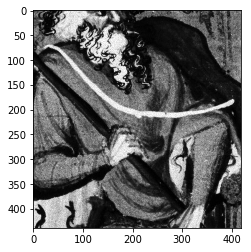

In [47]:
plt.imshow(imlist[np.random.randint(len(imlist))])

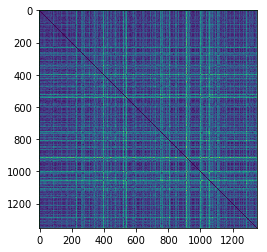

In [48]:
plt.imshow(gestures['valid']['distmat'])

## From here down, we're just visualising

In [49]:
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min
from os.path import join
import codecs

mytsne = TSNE(n_components=2, metric='precomputed')

In [50]:
xy_plot = mytsne.fit_transform(gestures['valid']['distmat'])

In [51]:
def get_magick_command(cmd):
    '''
    Return the specified imagemagick command prefaced with magick if
    the user is on Windows
    '''
    if os.name == 'nt':
        return 'magick ' + cmd
    return cmd

def filepath2name(filepath):
    return os.path.basename(filepath).split('.')[0]

def ensure_dir_exists(directory):
    '''
    Create the input directory if it doesn't exist
    '''
    if not os.path.exists(directory):
        os.makedirs(directory)

def subdivide(l, n):
    '''
    Return n-sized sublists from iterable l
    '''
    n = int(n)
    for i in range(0, len(l), n):
        yield l[i:i + n]

class PixPlotPose:
    
    def __init__(self, list_of_images, xyCoords):
        self.output_dir = './output/'
#         self.sizes = [16, 32]
        self.sizes = [16, 32, 64, 128]
        self.list_of_images = list_of_images
        self.nImages = len(list_of_images)
        self.xyCoords = xyCoords
        self.thumb_filenames = []
        self.thumb_sizes = []
        self.n_clusters = 20

    def create_output_dirs(self):
        '''
        Create each of the required output dirs
        '''
        dirs = ['image_vectors', 'atlas_files', 'thumbs']
        for i in dirs:
            ensure_dir_exists( join(self.output_dir, i) )
        # make subdirectories for each image thumb size
        for i in self.sizes:
            ensure_dir_exists( join(self.output_dir, 'thumbs', str(i) + 'px') )

    def save_thumbs(self):
#         image_sizes=[]
        for size in self.sizes:
            outpath = self.output_dir + 'thumbs/' + str(size) + 'px/'
            L = len(self.list_of_images)
            for i in range(L):
                outimage = self.list_of_images[i]
                
                if outimage.shape[0] > outimage.shape[1]:
                    outsize = [size, np.ceil(float(size)*outimage.shape[1]/outimage.shape[0])]
                else:
                    outsize = [np.ceil(float(size)*outimage.shape[0]/outimage.shape[1]), size]
#                 image_sizes.append(outsize)
#                 print(outsize)
#                 little hack for tiny images:
                tinyim = 0
                for k,a in enumerate(outsize):
                    if a == 0:
                        tinyim = 1
#                         print(i)
#                 print(outsize)
                if size == self.sizes[1]:
                    self.thumb_filenames.append(outpath+str(i)+'.jpg')
                    self.thumb_sizes.append(outsize)

                if not tinyim:
                    io.imsave(outpath+str(i)+'.jpg', transform.resize(outimage,outsize)) # add ,anti_aliasing=True
                if tinyim:
#                     rather than adding an exception, just make a black image here for now. 
                    if size == self.sizes[0]:
                        print('Image ' + str(i) + ' is impossible - making blank image')
                    almostBlankImage =  np.random.rand(size,size,3)
                    
                    io.imsave(outpath+str(i)+'.jpg',almostBlankImage)
            
            
    def get_centroids(self):
#         '''distmat
#         Use KMeans clustering to find n centroid images
#         that represent the center of an image cluster
#         '''
#         print(' * calculating ' + str(self.n_clusters) + ' clusters')
        model = KMeans(n_clusters=self.n_clusters)
        X = np.array(self.xyCoords)
        fit_model = model.fit(X)
        centroids = fit_model.cluster_centers_
#         # find the points closest to the cluster centroids
        closest, _ = pairwise_distances_argmin_min(centroids, X)
#         centroid_paths = [self.vector_files[i] for i in closest]
        centroid_json = []
#         for c, i in enumerate(centroid_paths):
        for i, closest in enumerate(closest):
            centroid_json.append({
#               'img': get_filename(i),
#               'label': 'Cluster ' + str(c+1)
              'img': str(closest) + '.jpg',
              'label': 'Cluster ' + str(i+1)
            })
        return centroid_json

    
    def get_image_positions(self):
        '''
        Write a JSON file that indicates the 2d position of each image
        '''
        print(' * writing JSON file')
        image_positions = []
        for i, coord in enumerate(self.xyCoords):
            height, width = self.thumb_sizes[i]

            image_positions.append([
              filepath2name(self.thumb_filenames[i]),
              int(coord[0] * 5),
              int(coord[1] * 5),
              width,
              height
            ])
        return image_positions
    
    
    
    def get_atlas_counts(self):
        file_count = self.nImages
        return {
          '32px': np.ceil( file_count / (64**2) ),
          '64px': np.ceil( file_count / (32**2) ),
          '128px': np.ceil( file_count / (16**2) ),
          '256px': np.ceil( file_count / (8**2) ),
          '512px': np.ceil( file_count / (4**2) )
        }

    def write_json(self):
        '''
        Write a JSON file with image positions, the number of atlas files
        in each size, and the centroids of the k means clusters
        '''
        print(' * writing main JSON plot data file')
        out_path = join(self.output_dir, 'plot_data.json')
        with open(out_path, 'w') as out:
            json.dump({
              'centroids': self.get_centroids(),
              'positions': self.get_image_positions(),
              'atlas_counts': self.get_atlas_counts(),
            }, out)

    def create_atlas_files(self):
        '''
        Create image atlas files in each required size
        '''
        print(' * creating atlas files')
        atlas_group_imgs = []
        for thumb_size in self.sizes:
            # identify the images for this atlas group
            atlas_thumbs = self.get_atlas_thumbs(thumb_size)
            atlas_group_imgs.append(len(atlas_thumbs))
            self.write_atlas_files(thumb_size, atlas_thumbs)
        # assert all image atlas files have the same number of images
        assert all(i == atlas_group_imgs[0] for i in atlas_group_imgs)


    def get_atlas_thumbs(self, thumb_size):
        thumbs = []
        thumb_dir = join(self.output_dir, 'thumbs', str(thumb_size) + 'px')
        with open(join(self.output_dir, 'plot_data.json')) as f:
            for i in json.load(f)['positions']:
                thumbs.append( join(thumb_dir, i[0] + '.jpg') )
        return thumbs

    def write_atlas_files(self, thumb_size, image_thumbs):
        '''
        Given a thumb_size (int) and image_thumbs [file_path],
        write the total number of required atlas files at this size
        '''
        # build a directory for the atlas files
        out_dir = join(self.output_dir, 'atlas_files', str(thumb_size) + 'px')
        ensure_dir_exists(out_dir)

        # specify number of columns in a 2048 x 2048px texture
        atlas_cols = 2048/thumb_size

        # subdivide the image thumbs into groups
        atlas_image_groups = subdivide(image_thumbs, atlas_cols**2)

        # generate a directory for images at this size if it doesn't exist
        for idx, atlas_images in enumerate(atlas_image_groups):
            print(' * creating atlas', idx + 1, 'at size', thumb_size)
            out_path = join(out_dir, 'atlas-' + str(idx) + '.jpg')
            # write a file containing a list of images for the current montage
            tmp_file_path = join(self.output_dir, 'images_to_montage.txt')
            with codecs.open(tmp_file_path, 'w', encoding='utf-8') as out:
                # python 2
                try:
                    out.write('\n'.join(map('"{0}"'.decode('utf-8').format, atlas_images)))
                # python 3
                except AttributeError:
                    out.write('\n'.join(map('"{0}"'.format, atlas_images)))

            # build the imagemagick command to montage the images
            cmd =  get_magick_command('montage') + ' @' + tmp_file_path + ' '
            cmd += '-background none '
            cmd += '-size ' + str(thumb_size) + 'x' + str(thumb_size) + ' '
            cmd += '-geometry ' + str(thumb_size) + 'x' + str(thumb_size) + '+0+0 '
            cmd += '-tile ' + str(atlas_cols) + 'x' + str(atlas_cols) + ' '
            cmd += '-quality 85 '
            cmd += '-sampling-factor 4:2:0 '
            cmd += '"' + out_path + '"'
            os.system(cmd)

        # delete the last images to montage file
#         try:
#             os.remove(tmp_file_path)
#         except Exception:
#             pass


In [52]:
PPP = PixPlotPose(gestures['valid']['images'], xy_plot)
PPP.create_output_dirs()

In [53]:
PPP.save_thumbs()

/home/leonardo/.conda/envs/tensorflow/lib/python3.5/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/leonardo/.conda/envs/tensorflow/lib/python3.5/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/leonardo/.conda/envs/tensorflow/lib/python3.5/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


Image 789 is impossible - making blank image


In [54]:
PPP.write_json()

 * writing main JSON plot data file
 * writing JSON file


In [55]:
PPP.create_atlas_files()

 * creating atlas files
 * creating atlas 1 at size 16
 * creating atlas 1 at size 32
 * creating atlas 1 at size 64
 * creating atlas 2 at size 64
 * creating atlas 1 at size 128
 * creating atlas 2 at size 128
 * creating atlas 3 at size 128
 * creating atlas 4 at size 128
 * creating atlas 5 at size 128
 * creating atlas 6 at size 128
